# **Load Data**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [ ]:
train = pd.read_csv("https://raw.githubusercontent.com/hsaripalli/Pump-It-Up/main/datasets/Training_set_values.csv")
labels = pd.read_csv("https://raw.githubusercontent.com/hsaripalli/Pump-It-Up/main/datasets/Training_set_labels.csv")
#test = pd.read_csv("https://raw.githubusercontent.com/hsaripalli/Pump-It-Up/main/datasets/Test_set_values.csv")

In [ ]:
values = pd.merge(train, labels, on = 'id')
values

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,Pangani,Kiduruni,Kilimanjaro,3,5,Hai,Masama Magharibi,125,True,GeoData Consultants Ltd,Water Board,Losaa Kia water supply,True,1999,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,Rufiji,Igumbilo,Iringa,11,4,Njombe,Ikondo,56,True,GeoData Consultants Ltd,VWC,Ikondo electrical water sch,True,1996,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,Rufiji,Madungulu,Mbeya,12,7,Mbarali,Chimala,0,True,GeoData Consultants Ltd,VWC,NaN,False,0,swn 80,swn 80,handpump,vwc,user-group,pay monthly,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,functional
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,Rufiji,Mwinyi,Dodoma,1,4,Chamwino,Mvumi Makulu,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional


In [ ]:
values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [ ]:
values.select_dtypes(include = ['object']).nunique()

date_recorded              356
funder                    1897
installer                 2145
wpt_name                 37400
basin                        9
subvillage               19287
region                      21
lga                        125
ward                      2092
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
status_group                 3
dtype: int64

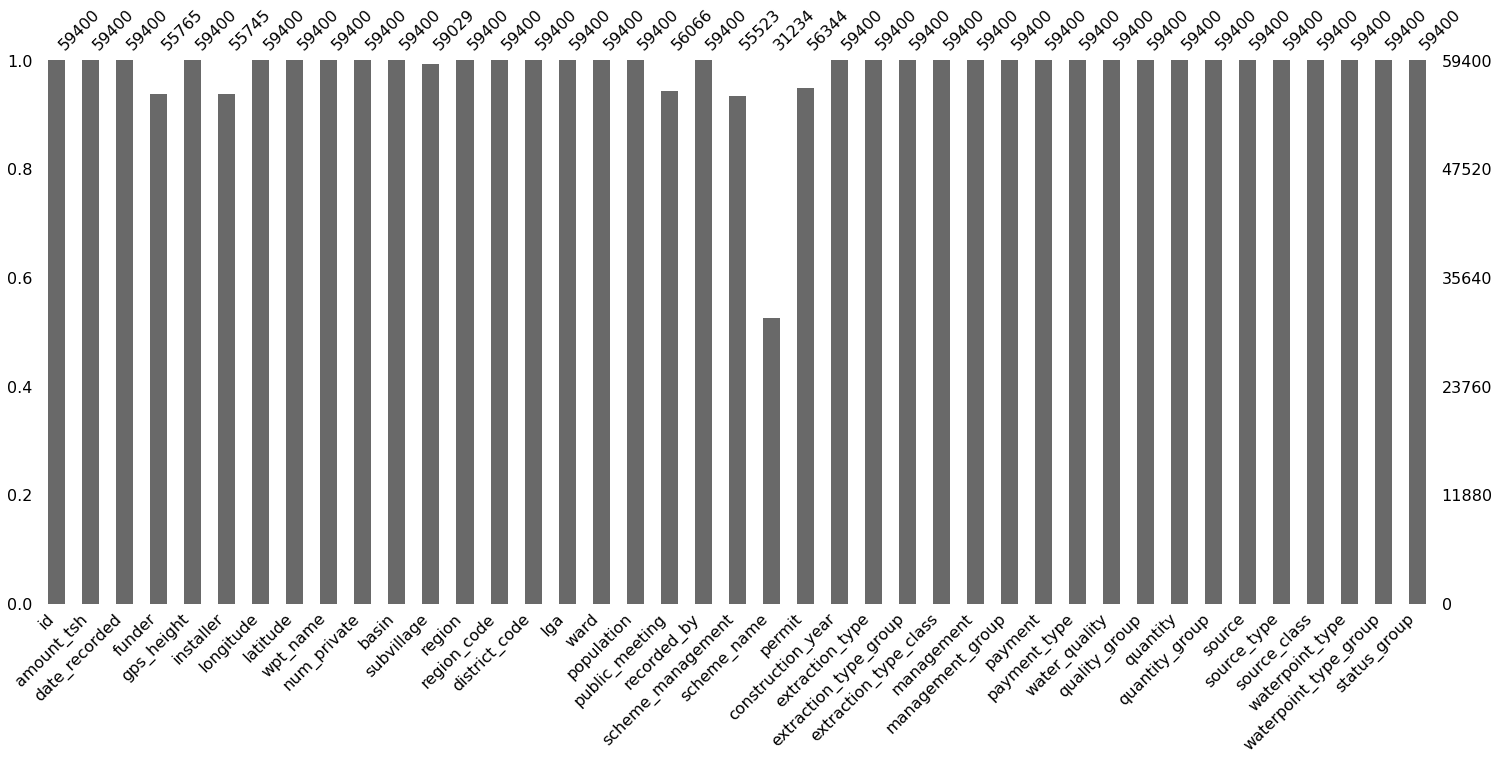

In [ ]:
import missingno as msno

msno.bar(values)

# **Data Cleaning - Numerical Features**

In [ ]:
values['date_recorded' + '_year'] = pd.to_datetime(values['date_recorded']).dt.year 
values['date_recorded' + '_month'] = pd.to_datetime(values['date_recorded']).dt.month
values = values.drop('date_recorded', axis = 1)

In [ ]:
# Impute small latitude values with 0
values.loc[values['latitude'] > -0.5, 'latitude'] = 0

In [ ]:
# gps height and longitude: impute 0 and nan with grouped mean
col1 = ['gps_height', 'longitude', 'latitude']
values[col1] = values [col1].replace(0, np.nan)
for i in col1:
    values[i] = values[i].fillna(values.groupby('subvillage')[i].transform('mean'))
    values[i] = values[i].fillna(values.groupby('ward')[i].transform('mean'))
    values[i] = values[i].fillna(values.groupby('lga')[i].transform('mean'))
    values[i] = values[i].fillna(values.groupby('region')[i].transform('mean'))
    values[i] = values[i].fillna(values.groupby('basin')[i].transform('mean'))

In [ ]:
# construction year and population: impute 0 and nan with most frequent
col2 = ['construction_year', 'population']
values[col2] = values[col2].replace(0, np.nan)
for i in col2:
    values[i] = round(values[i].fillna(values.groupby('subvillage')[i].transform('mean')))
    values[i] = round(values[i].fillna(values.groupby('ward')[i].transform('mean')))
    values[i] = round(values[i].fillna(values.groupby('lga')[i].transform('mean')))
    values[i] = round(values[i].fillna(values.groupby('region')[i].transform('mean')))
    values[i] = round(values[i].fillna(values.groupby('basin')[i].transform('mean')))

In [ ]:
# Add age = date recordced - construction year
# Impute negative age with 1
values['age'] = values['date_recorded_year'] - values['construction_year']
values.loc[values['age'] < 0, 'age'] = 1

In [ ]:
values['age'].describe()

count    59400.000000
mean        15.496498
std         10.742564
min          0.000000
25%          7.000000
50%         14.000000
75%         21.000000
max         53.000000
Name: age, dtype: float64

In [ ]:
# COLUMNS WITH TOO MANY UNIQUE VALUES

#funder                    1897
#installer                 2145
#wpt_name                 37400
#subvillage               19287
#lga                        125
#ward                      2092
#scheme_name               2696

# **Insights**

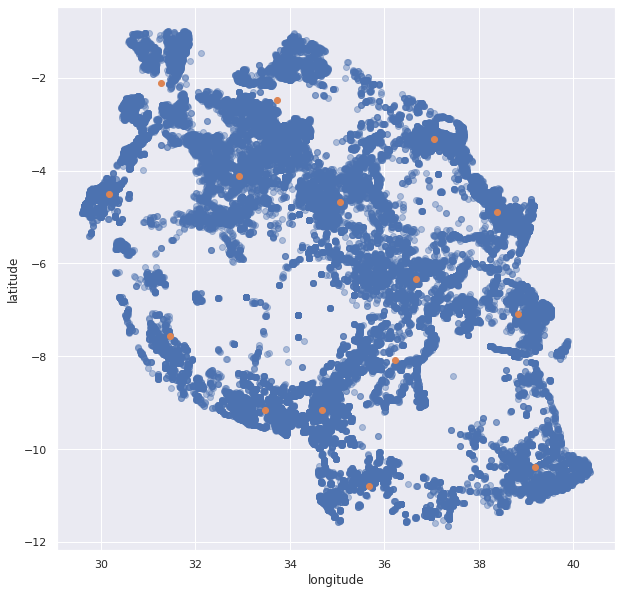

In [ ]:
from sklearn.cluster import KMeans

clusters = 15
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(values[['longitude', 'latitude']].values)
fig, ax1 = plt.subplots(figsize=(10, 10))
ax1.scatter(values.longitude, values.latitude, alpha=0.4, label='samples')
ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], label='centers')
ax1.set_ylabel('latitude')
ax1.set_xlabel('longitude')
kmean_feats = pd.DataFrame(kmeans.fit_transform(values[['longitude', 'latitude']].values), columns=['gspatial_' + str(i) for i in range(clusters)])

(0.5, 26.0)

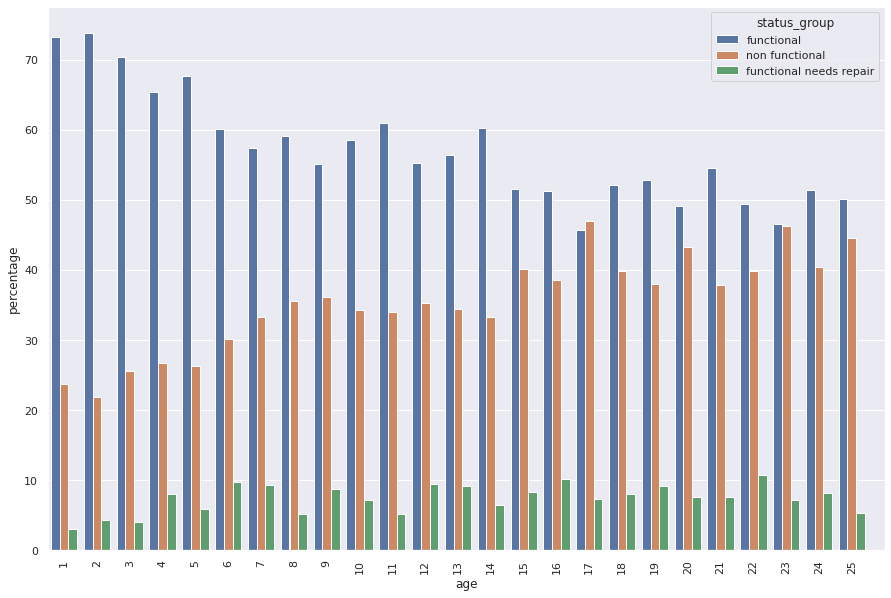

In [ ]:
age_counts = (values.groupby(['age'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('age'))
p = sns.barplot(x="age", y="percentage", hue="status_group", data=age_counts, order=values.age.iloc[:26].index)
_ = plt.setp(p.get_xticklabels(), rotation=90)
plt.xlim(0.5,26)  # Rotate labels

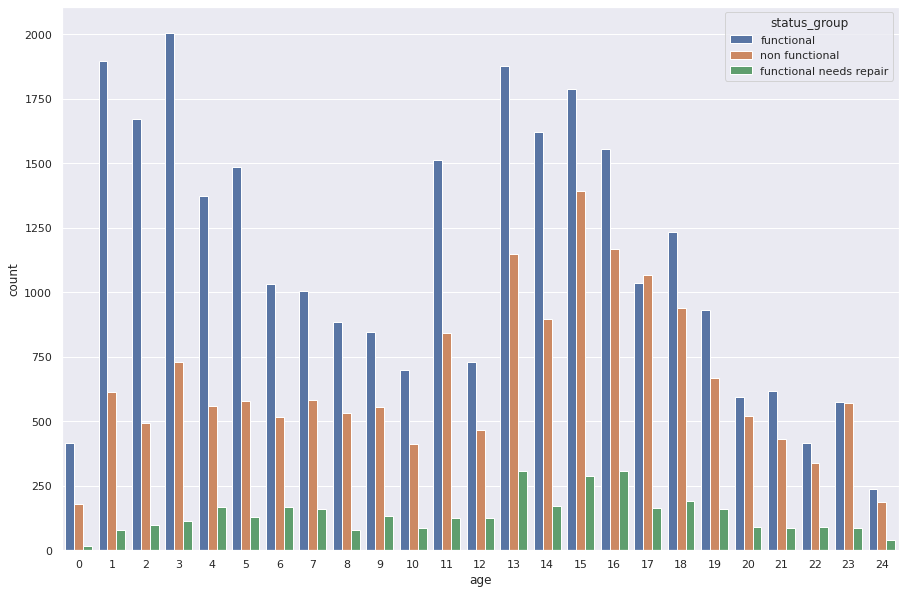

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})

age = sns.countplot(x = 'age', data = values, hue = 'status_group', 
                       order=values.age.iloc[:25].index)

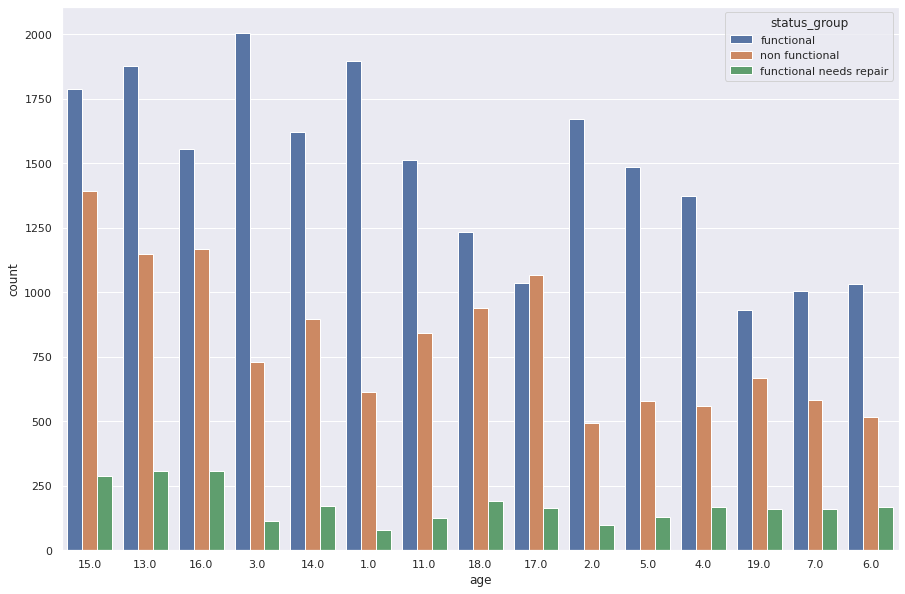

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})

age = sns.countplot(x = 'age', data = values, hue = 'status_group',
                       order=values.age.value_counts(normalize=True).iloc[:15].index)

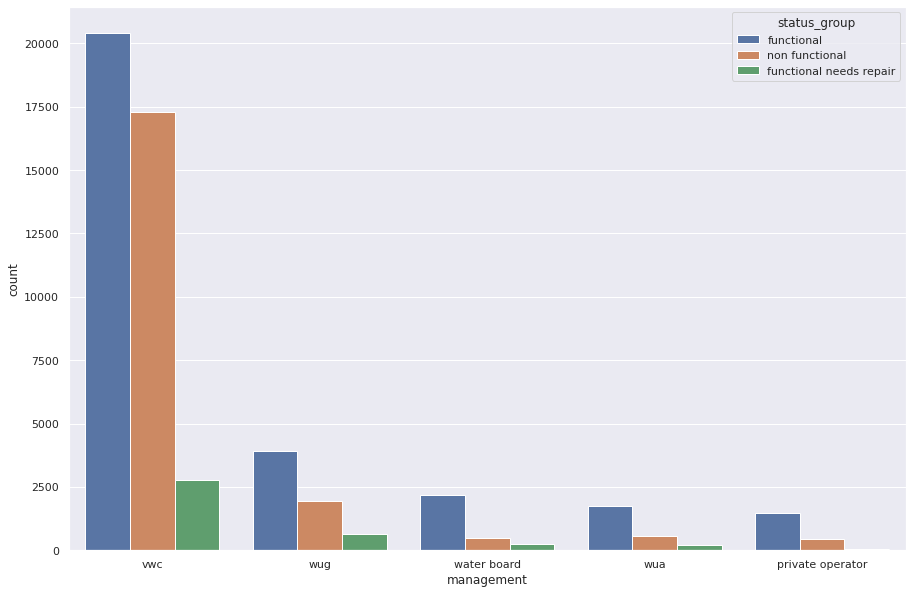

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})

management = sns.countplot(x = 'management', data = values, hue = 'status_group',
                       order=values.management.value_counts(normalize=True).iloc[:5].index)

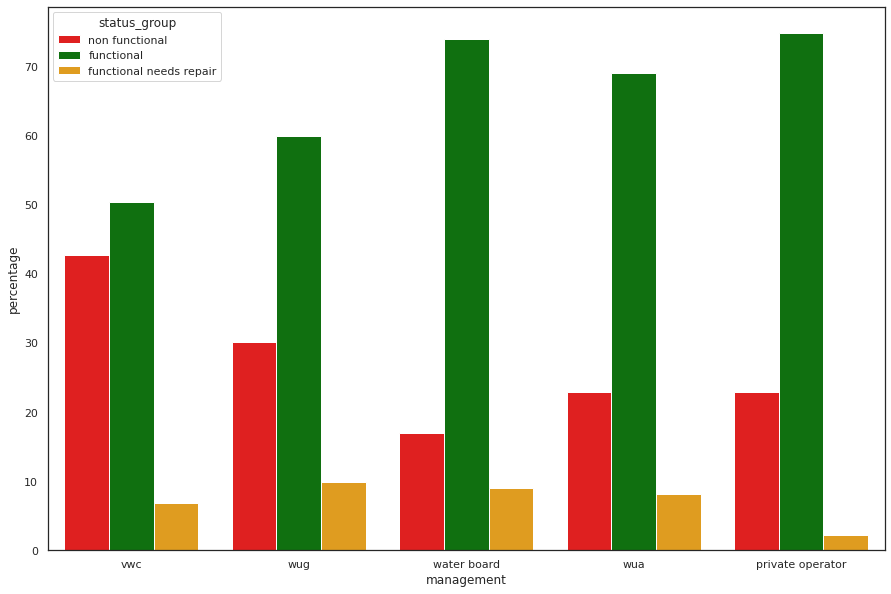

In [ ]:
sns.set_style("white")


management_counts = (values.groupby(['management'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())
p = sns.barplot(x="management", y="percentage", hue="status_group", data=management_counts,
                palette = {"functional":"green",
                           "non functional":"red", 
                           "functional needs repair":"orange"},
                order=values.management.value_counts(normalize=True).iloc[:5].index)

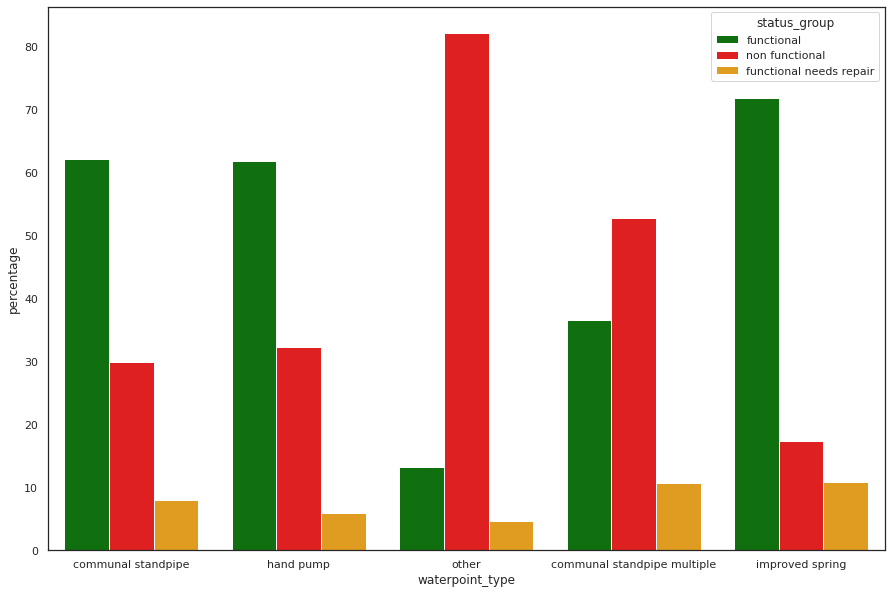

In [ ]:
waterpoint_type_counts = (values.groupby(['waterpoint_type'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())
p = sns.barplot(x="waterpoint_type", y="percentage", hue="status_group", data=waterpoint_type_counts,
                palette = {"functional":"green",
                           "non functional":"red", 
                           "functional needs repair":"orange"},
                order=values.waterpoint_type.value_counts(normalize=True).iloc[:5].index)

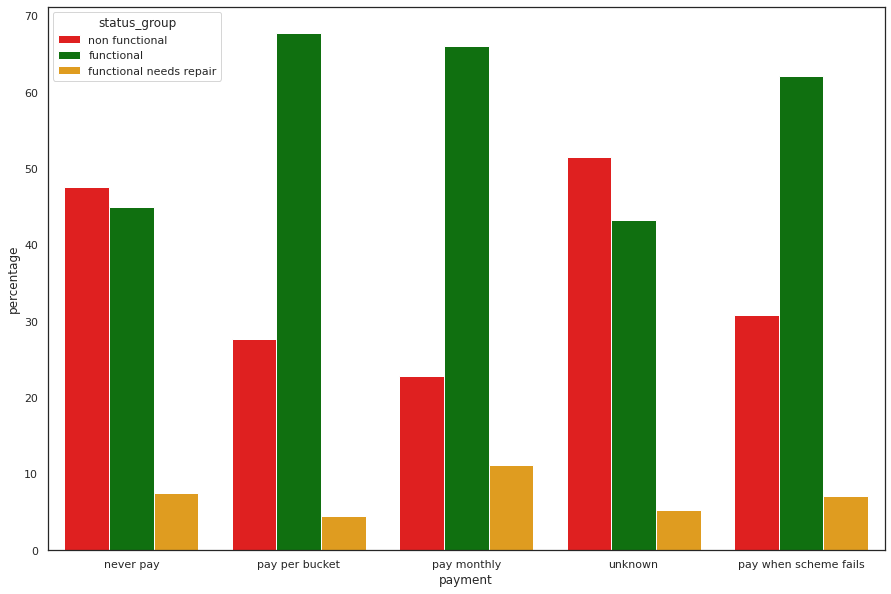

In [ ]:
payment_counts = (values.groupby(['payment'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())
p = sns.barplot(x="payment", y="percentage", hue="status_group", data=payment_counts,
                palette = {"functional":"green",
                           "non functional":"red", 
                           "functional needs repair":"orange"},
                order=values.payment.value_counts(normalize=True).iloc[:5].index)

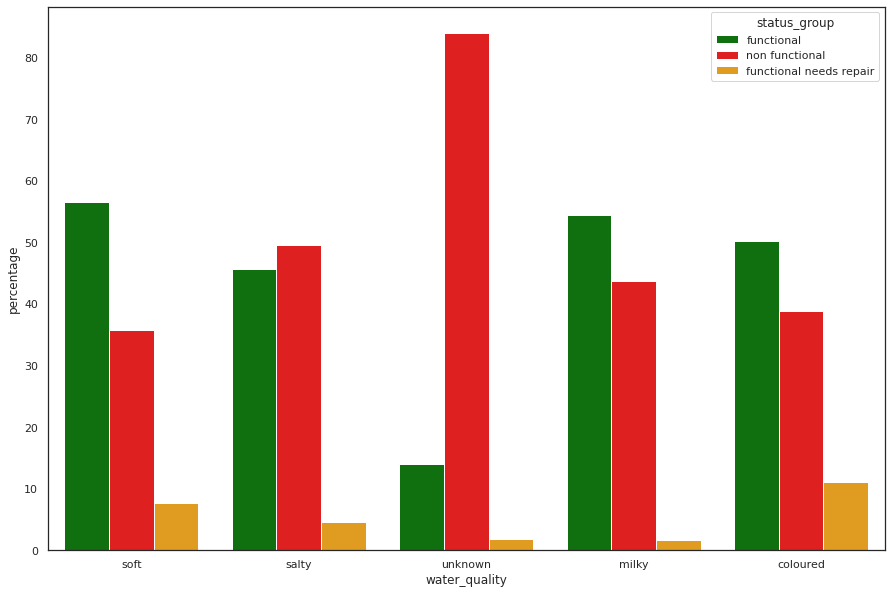

In [ ]:
water_quality_counts = (values.groupby(['water_quality'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())
p = sns.barplot(x="water_quality", y="percentage", hue="status_group", data=water_quality_counts,
                palette = {"functional":"green",
                           "non functional":"red", 
                           "functional needs repair":"orange"},
                order=values.water_quality.value_counts(normalize=True).iloc[:5].index)

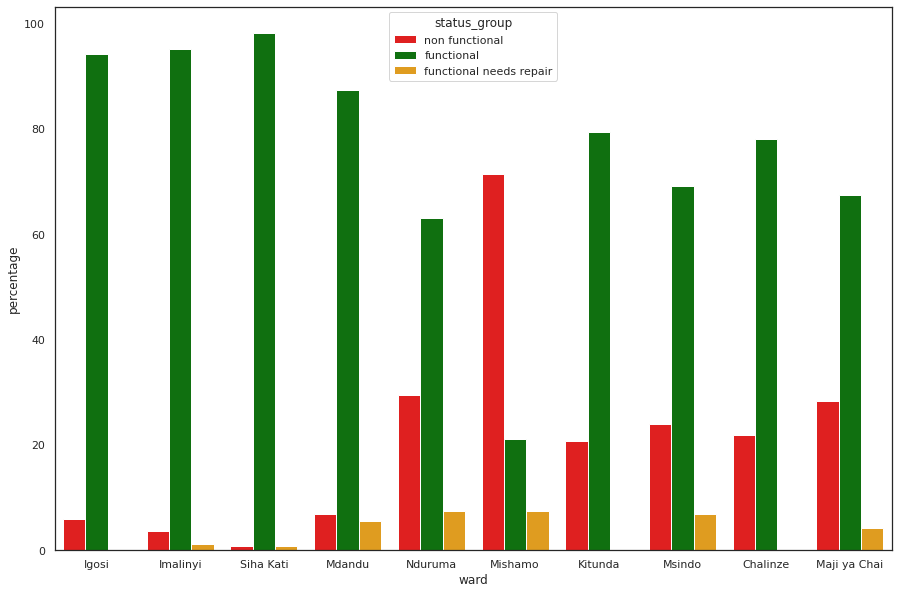

In [ ]:
ward_counts = (values.groupby(['ward'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())
p = sns.barplot(x="ward", y="percentage", hue="status_group", data=ward_counts,
                palette = {"functional":"green",
                           "non functional":"red", 
                           "functional needs repair":"orange"},
                order=values.ward.value_counts(normalize=True).iloc[:10].index)

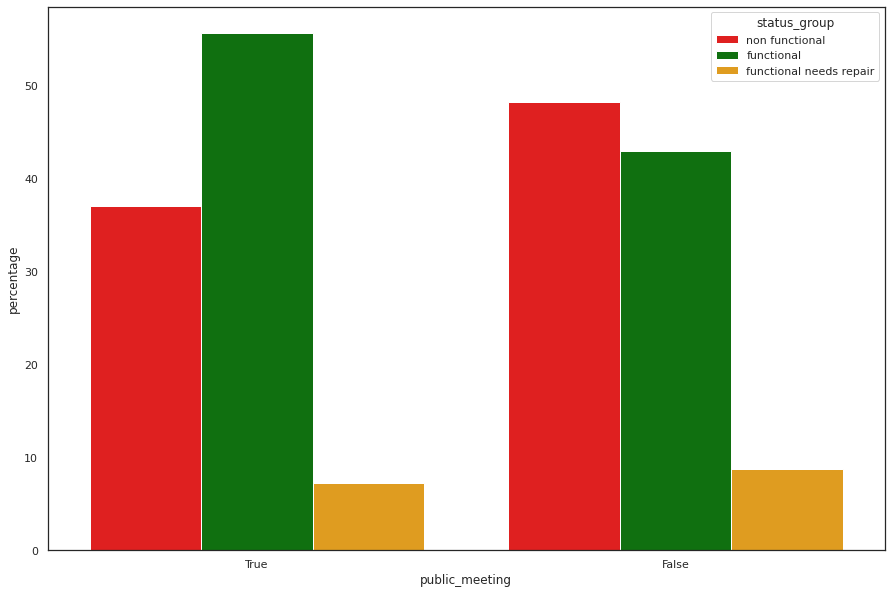

In [ ]:
public_meeting_counts = (values.groupby(['public_meeting'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())
p = sns.barplot(x="public_meeting", y="percentage", hue="status_group", data=public_meeting_counts,
                palette = {"functional":"green",
                           "non functional":"red", 
                           "functional needs repair":"orange"},
                order=values.public_meeting.value_counts(normalize=True).iloc[:5].index)

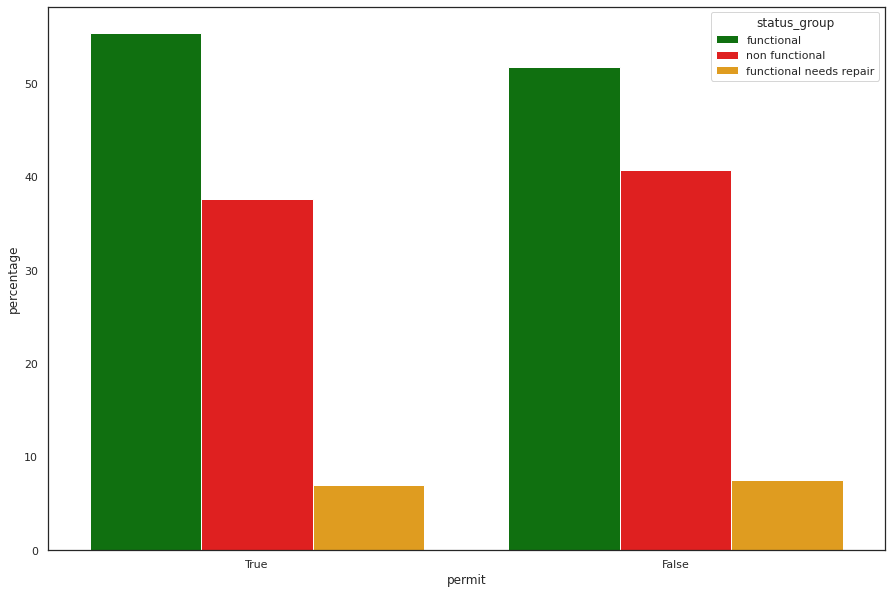

In [ ]:
permit_counts = (values.groupby(['permit'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())
p = sns.barplot(x="permit", y="percentage", hue="status_group", data=permit_counts,
                palette = {"functional":"green",
                           "non functional":"red", 
                           "functional needs repair":"orange"},
                order=values.permit.value_counts(normalize=True).iloc[:5].index)

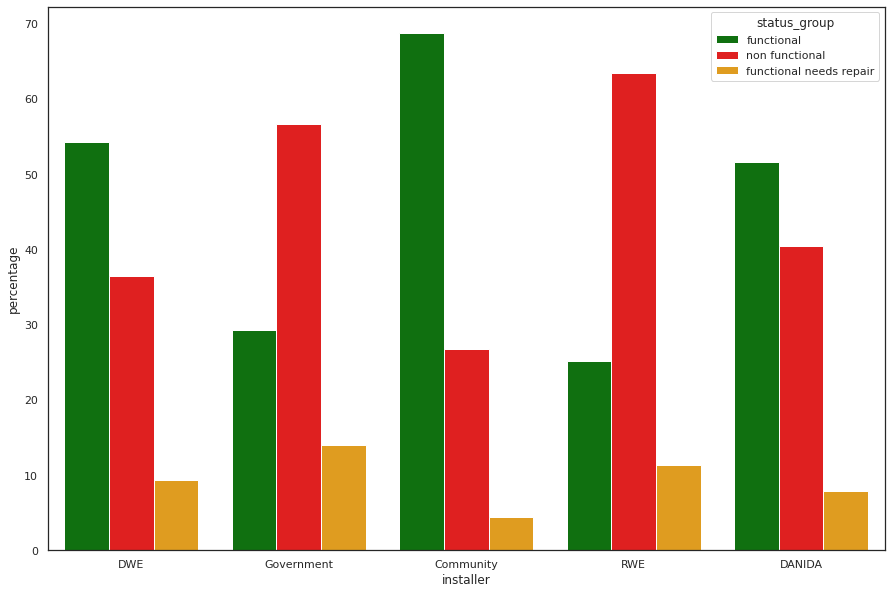

In [ ]:
installer_counts = (values.groupby(['installer'])['status_group']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())
p = sns.barplot(x="installer", y="percentage", hue="status_group", data=installer_counts,
                palette = {"functional":"green",
                           "non functional":"red", 
                           "functional needs repair":"orange"},
                order=values.installer.value_counts(normalize=True).iloc[:5].index)

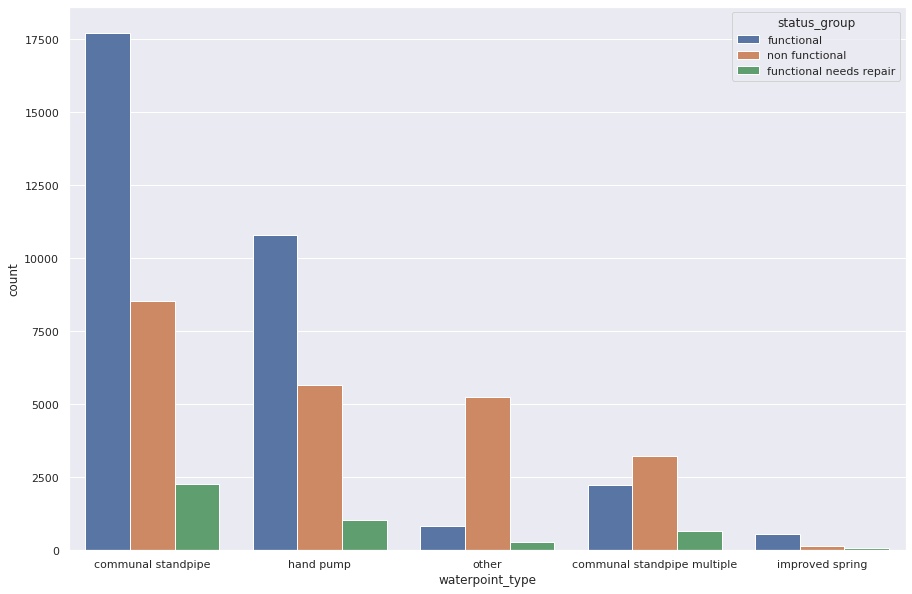

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})

waterpoint_type = sns.countplot(x = 'waterpoint_type', data = values, hue = 'status_group',
                       order=values.waterpoint_type.value_counts(normalize=True).iloc[:5].index)

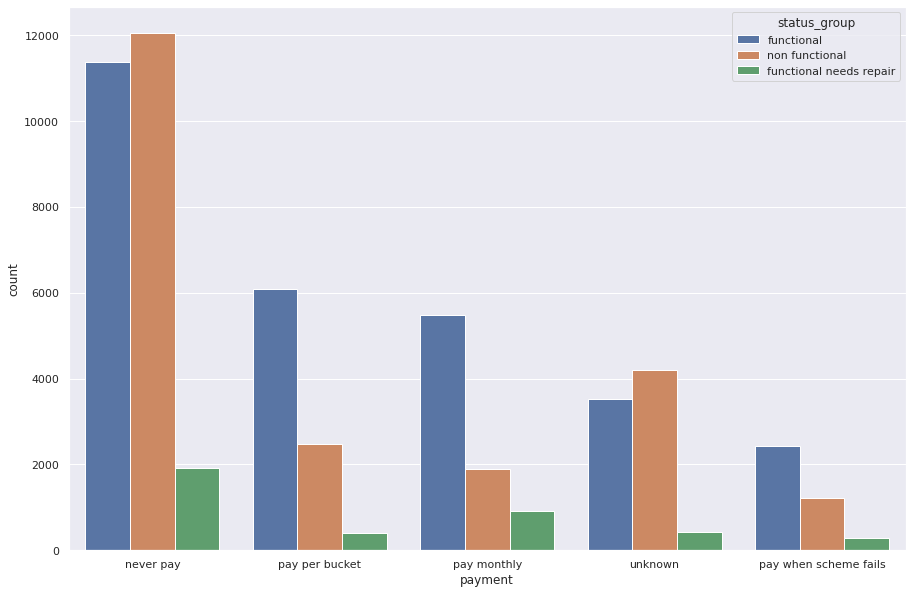

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})

payment = sns.countplot(x = 'payment', data = values, hue = 'status_group',
                       order=values.payment.value_counts(normalize=True).iloc[:5].index)

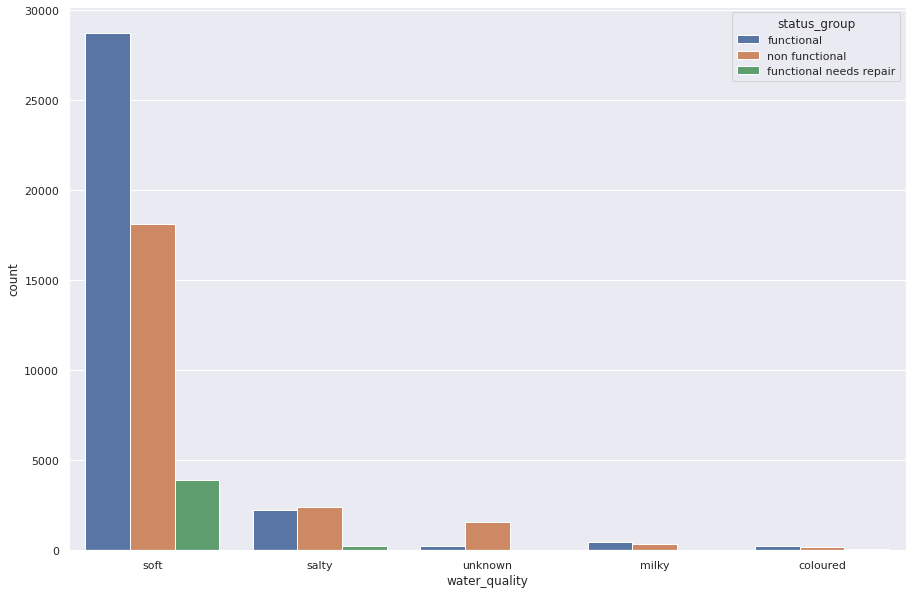

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})

water_quality = sns.countplot(x = 'water_quality', data = values, hue = 'status_group',
                       order=values.water_quality.value_counts(normalize=True).iloc[:5].index)

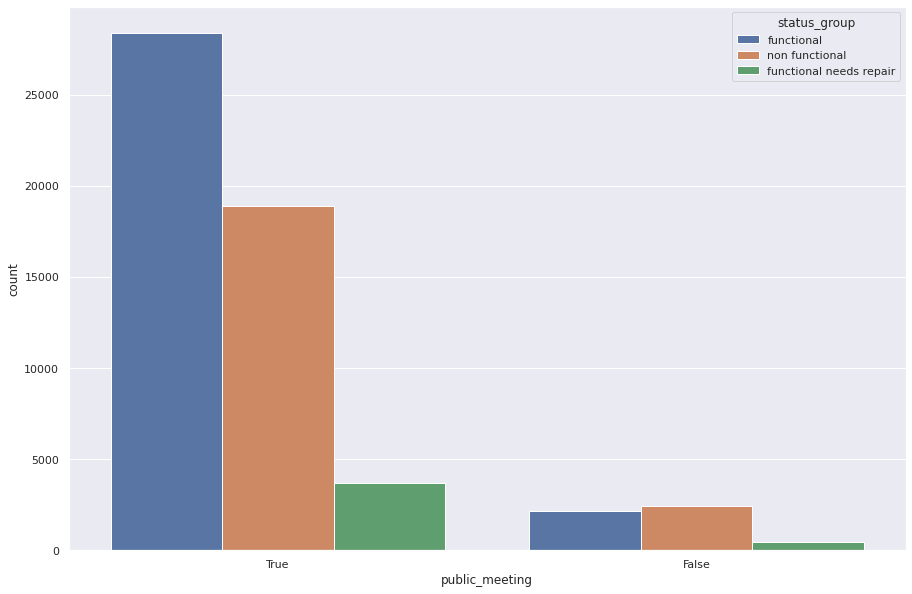

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})

public_meeting = sns.countplot(x = 'public_meeting', data = values, hue = 'status_group',
                       order=values.public_meeting.value_counts(normalize=True).iloc[:5].index)

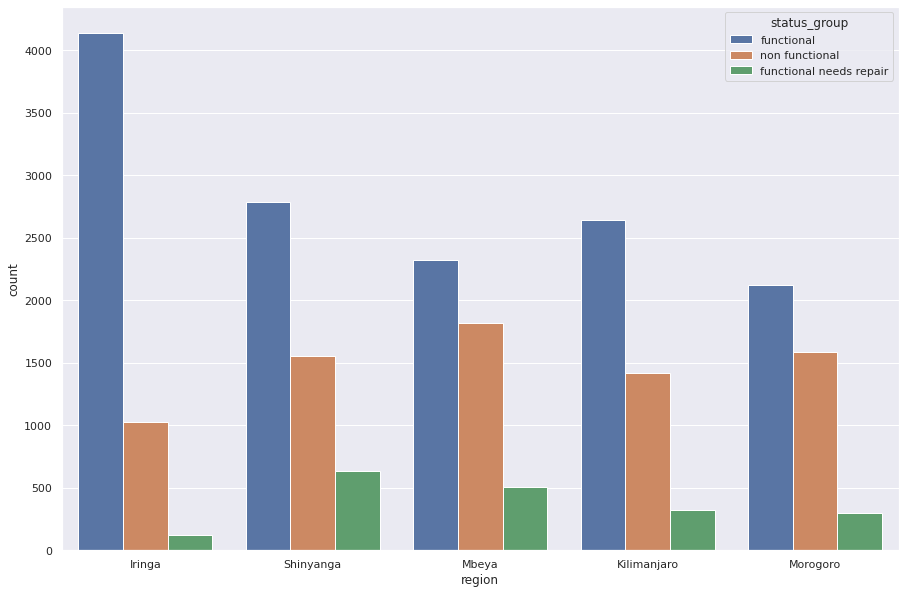

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})

region = sns.countplot(x = 'region', data = values, hue = 'status_group',
                       order=values.region.value_counts(normalize=True).iloc[:5].index) 

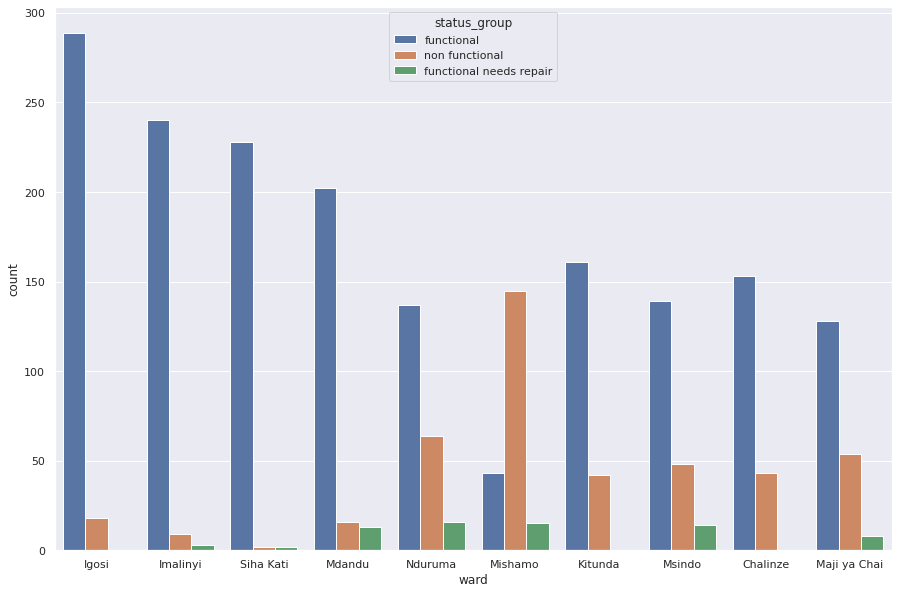

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})

region = sns.countplot(x = 'ward', data = values, hue = 'status_group',
                       order=values.ward.value_counts(normalize=True).iloc[:10].index) 

In [ ]:
values['installer'] = values['installer'].replace(to_replace = ('gover'), value = 'government')
values['installer'] = values['installer'].replace(to_replace = ('Commu'), value = 'Community')

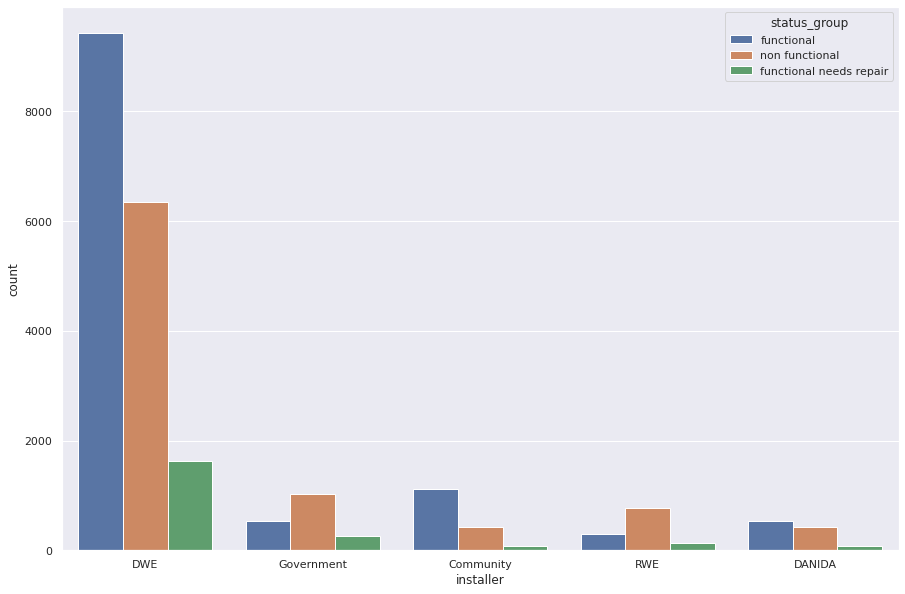

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})

installer = sns.countplot(x = 'installer', data = values, hue = 'status_group',
                       order=values.installer.value_counts(normalize=True).iloc[:5].index) 

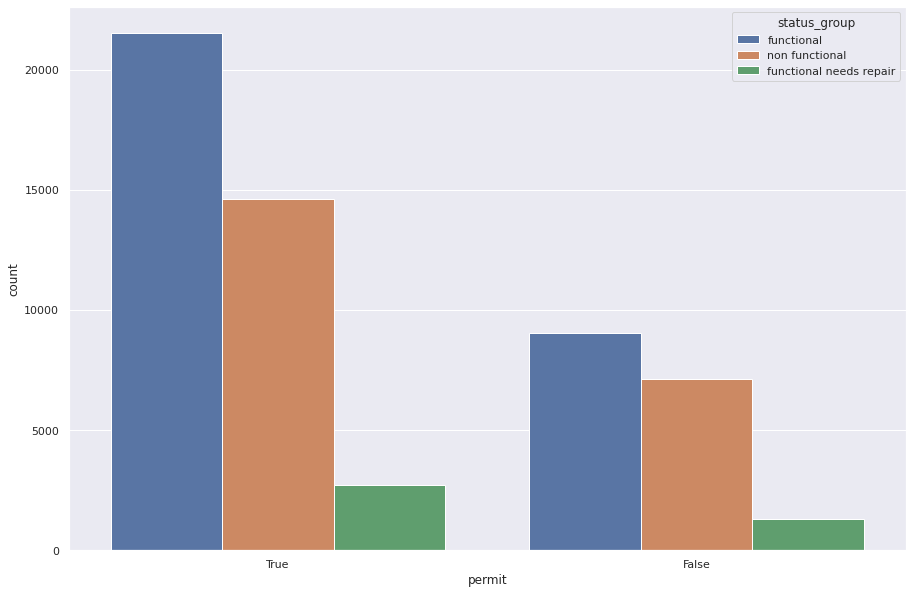

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})

permit = sns.countplot(x = 'permit', data = values, hue = 'status_group',
                       order=values.permit.value_counts(normalize=True).iloc[:5].index)

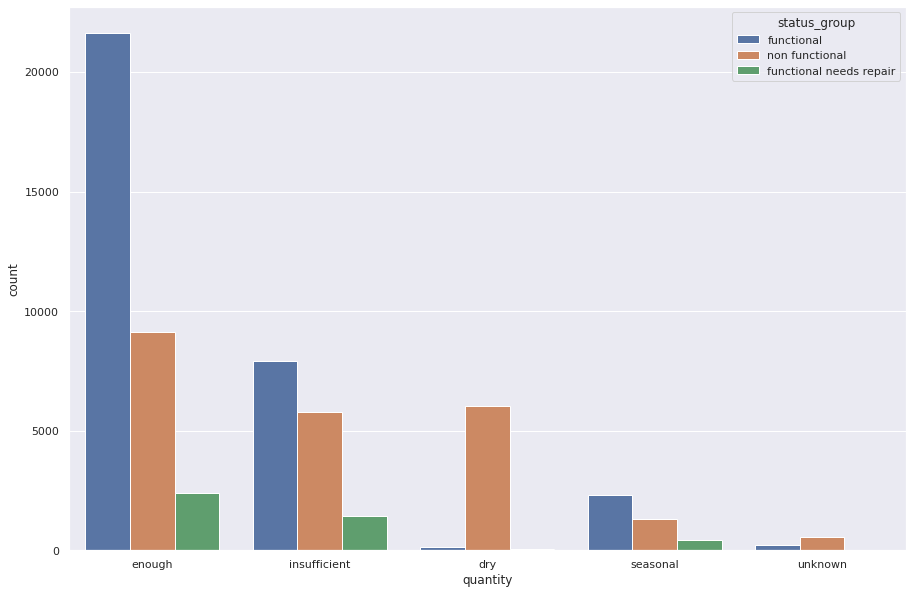

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})

quantity = sns.countplot(x = 'quantity', data = values, hue = 'status_group',
                       order=values.quantity.value_counts(normalize=True).iloc[:5].index)

# *EDA Plots*

In [ ]:
sns.set(rc = {'figure.figsize':(15,10)})

funder = sns.countplot(y = 'funder', data = values,
                       order=values.funder.value_counts().iloc[:25].index)

In [ ]:
installer = sns.countplot(y = 'installer', data = values,
                       order=values.installer.value_counts().iloc[:25].index)

In [ ]:
wpt_name = sns.countplot(y = 'wpt_name', data = values,
                       order=values.wpt_name.value_counts().iloc[:25].index)

In [ ]:
subvillage = sns.countplot(y = 'subvillage', data = values,
                       order=values.subvillage.value_counts().iloc[:25].index)

In [ ]:
lga = sns.countplot(y = 'lga', data = values,
                       order=values.lga.value_counts().iloc[:25].index)

In [ ]:
scheme_name = sns.countplot(y = 'scheme_name', data = values,
                       order=values.scheme_name.value_counts().iloc[:25].index)

#Many 'None' and missing values. Remove column

In [ ]:
# COLUMNS WITH NOT TOO MANY UNIQUE

#COLUMN                      #UNIQUE VALUES
#basin                        9
#region                      21
#public_meeting               2
#recorded_by                  1
#scheme_management           12
#permit                       2
#extraction_type             18
#extraction_type_group       13
#extraction_type_class        7
#management                  12
#management_group             5
#payment                      7
#payment_type                 7
#water_quality                8
#quality_group                6
#quantity                     5
#quantity_group               5
#source                      10
#source_type                  7
#source_class                 3
#waterpoint_type              7
#waterpoint_type_group        6

In [ ]:
basin = sns.countplot(y = 'basin', data = values, 
                      order=values.basin.value_counts().iloc[:25].index)

In [ ]:
region = sns.countplot(y = 'region', data = values,
                       order=values.region.value_counts().iloc[:25].index)

In [ ]:
public_meeting = sns.countplot(y = 'public_meeting', data = values,
                       order=values.public_meeting.value_counts().iloc[:25].index)

In [ ]:
recorded_by = sns.countplot(y = 'recorded_by', data = values)
                       #order=values.scheme_name.value_counts().iloc[:25].index)

# Only 1 value, column can be removed

In [ ]:
permit = sns.countplot(y = 'permit', data = values,
                       order=values.permit.value_counts().iloc[:25].index)

In [ ]:
extraction_type = sns.countplot(y = 'extraction_type', data = values,
                       order=values.extraction_type.value_counts().iloc[:25].index)

In [ ]:
extraction_type_class = sns.countplot(y = 'extraction_type_class', data = values,
                       order=values.extraction_type_class.value_counts().iloc[:25].index)

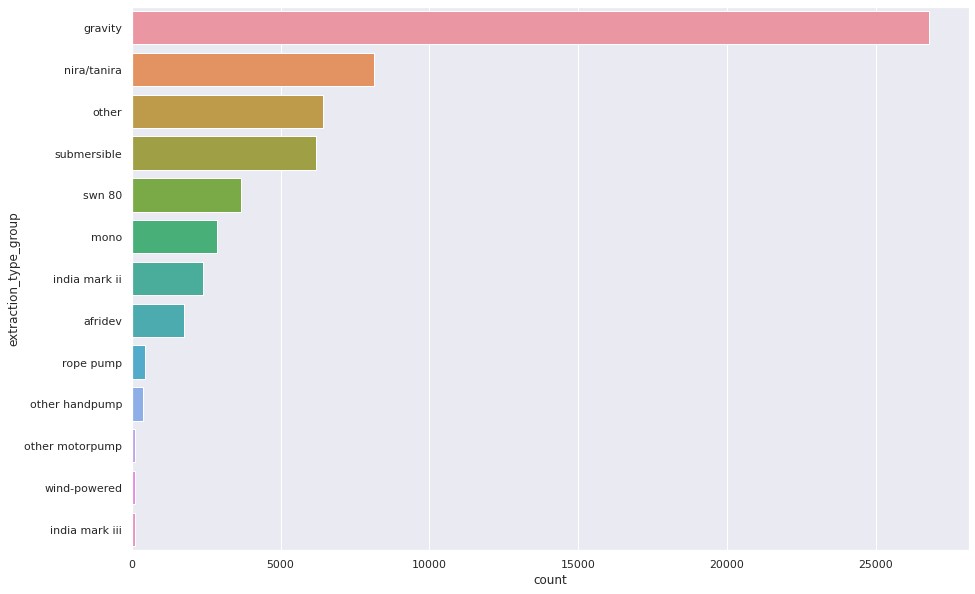

In [ ]:
extraction_type_group = sns.countplot(y = 'extraction_type_group', data = values,
                       order=values.extraction_type_group.value_counts().iloc[:25].index)

In [ ]:
management = sns.countplot(y = 'management', data = values,
                       order=values.management.value_counts().iloc[:25].index)

In [ ]:
management_group = sns.countplot(y = 'management_group', data = values,
                       order=values.management_group.value_counts().iloc[:25].index)

In [ ]:
payment = sns.countplot(y = 'payment', data = values,
                       order=values.payment.value_counts().iloc[:25].index)

In [ ]:
payment_type = sns.countplot(y = 'payment_type', data = values,
                       order=values.payment_type.value_counts().iloc[:25].index)

In [ ]:
water_quality = sns.countplot(y = 'water_quality', data = values,
                       order=values.water_quality.value_counts().iloc[:25].index)

In [ ]:
quality_group = sns.countplot(y = 'quality_group', data = values,
                       order=values.quality_group.value_counts().iloc[:25].index)

In [ ]:
quantity = sns.countplot(y = 'quantity', data = values,
                       order=values.quantity.value_counts().iloc[:25].index)

In [ ]:
quantity_group = sns.countplot(y = 'quantity_group', data = values,
                       order=values.quantity_group.value_counts().iloc[:25].index)

In [ ]:
#source                      10
#source_type                  7
#source_class                 3
#waterpoint_type              7
#waterpoint_type_group        6

In [ ]:
source = sns.countplot(y = 'source', data = values,
                       order=values.source.value_counts().iloc[:25].index)

In [ ]:
source_type = sns.countplot(y = 'source_type', data = values,
                       order=values.source_type.value_counts().iloc[:25].index)

In [ ]:
source_class = sns.countplot(y = 'source_class', data = values,
                       order=values.source_class.value_counts().iloc[:25].index)

In [ ]:
waterpoint_type = sns.countplot(y = 'waterpoint_type', data = values,
                                order=values.waterpoint_type.value_counts().iloc[:25].index)

In [ ]:
waterpoint_type_group = sns.countplot(y = 'waterpoint_type_group', data = values,
                       order=values.waterpoint_type_group.value_counts().iloc[:25].index)

In [ ]:
# NUMERICAL COLUMNS

#id  (remove)                  
#amount_tsh  (remove)        
#gps_height          
#longitude             
#latitude              
#num_private           
#region_code           
#district_code         
#population             
#construction_year     

sns.set(rc = {'figure.figsize':(20,10)})

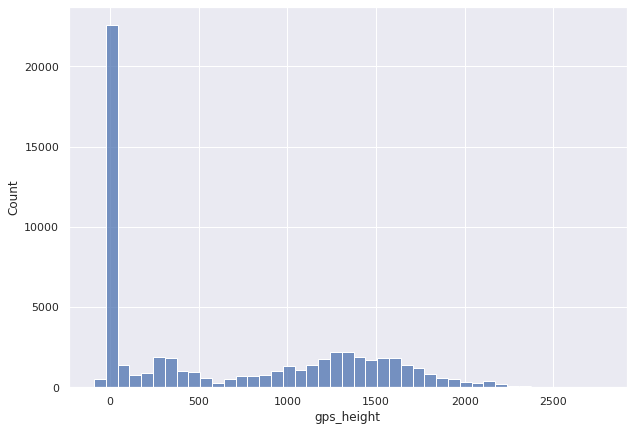

In [ ]:
sns.set(rc = {'figure.figsize':(10,7)})
sns.histplot(values['gps_height'])

# Zero and negative gps_height. Leave or impute: group by region ? 

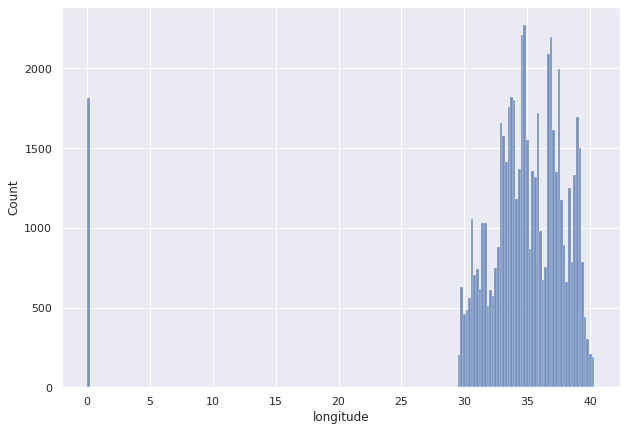

In [ ]:
sns.histplot(values['longitude'])

# Zero longitude. It is a point in the atlantic ocean. Impute: group by region ? 


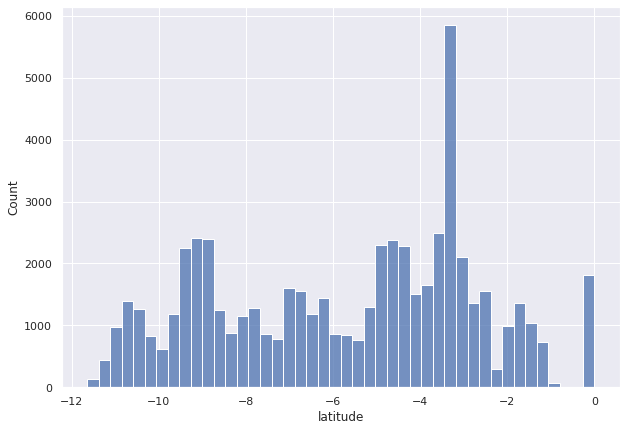

In [ ]:
sns.histplot(values['latitude'])

Text(0.5, 0, 'latitude')

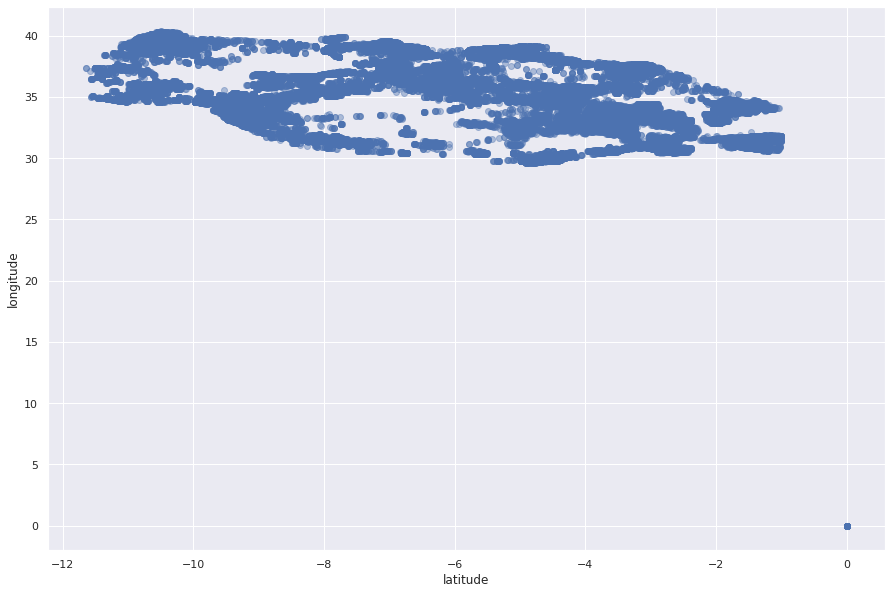

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 10))
ax1.scatter(values.latitude, values.longitude, alpha=0.4, label='samples')
ax1.set_ylabel('longitude')
ax1.set_xlabel('latitude')

(0.0, 150.0)

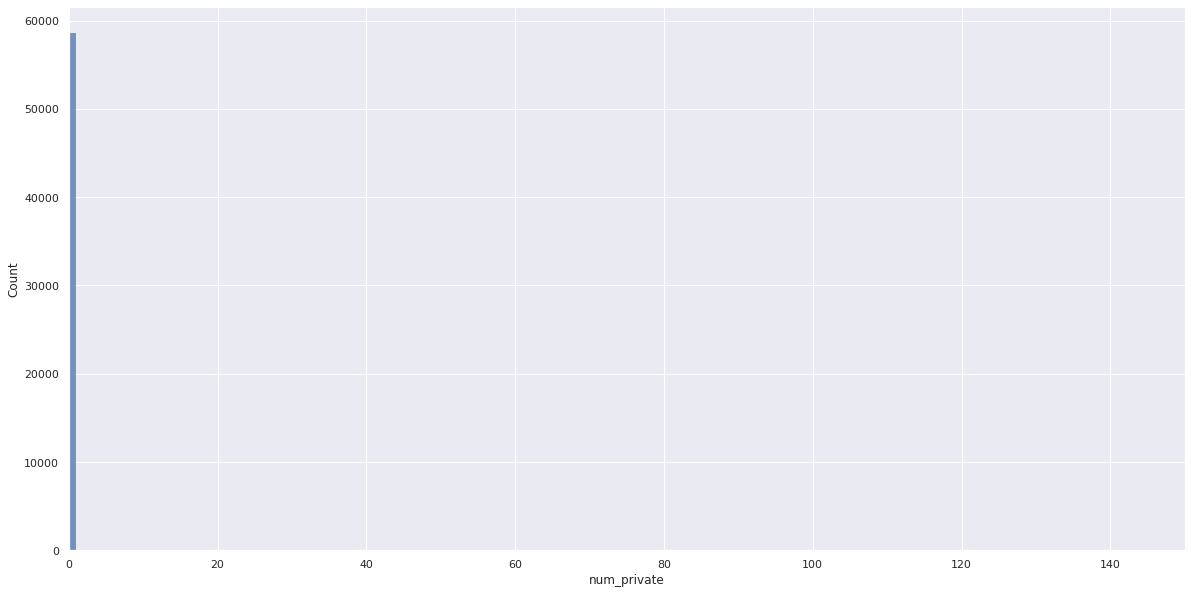

In [ ]:
sns.histplot(values['num_private'], binwidth=1)
plt.xlim(0,150)

# All zeroes: remove column

array([11, 20, 21, 90, 18,  4, 17, 14, 60, 10,  3, 15, 19, 16, 80,  1,  6,
        2, 12, 13,  5,  7, 99, 24,  9,  8, 40])

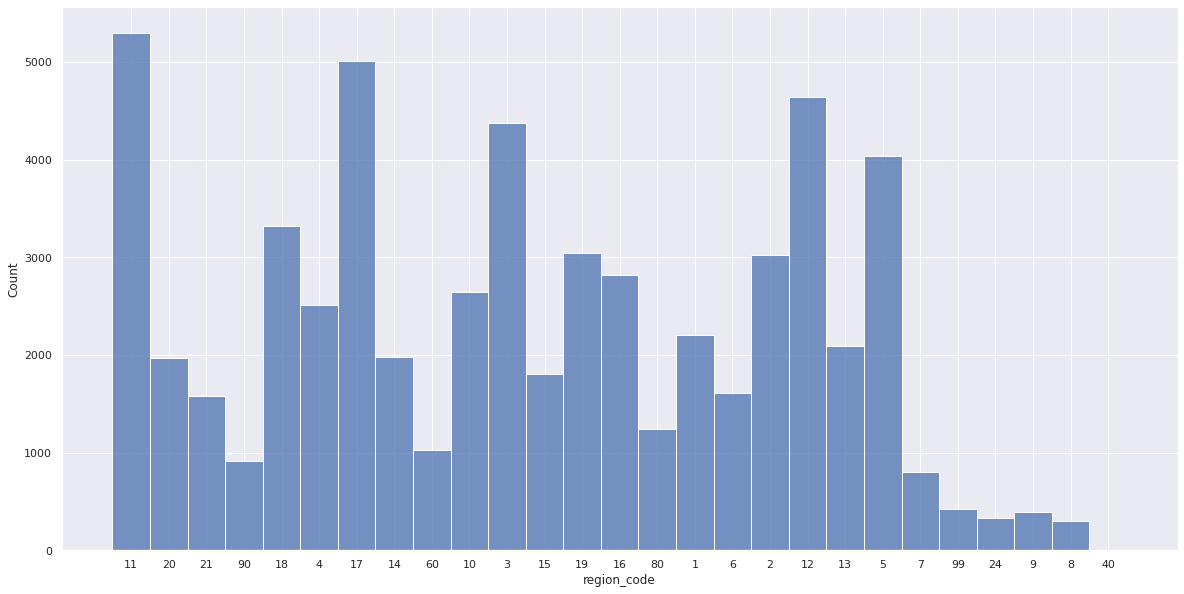

In [ ]:
sns.histplot(values['region_code'].astype(str))
values['region_code'].unique()


array([ 5,  2,  4, 63,  1,  8,  3,  6, 43,  7, 23, 33, 53, 62, 60, 30, 13,
        0, 80, 67])

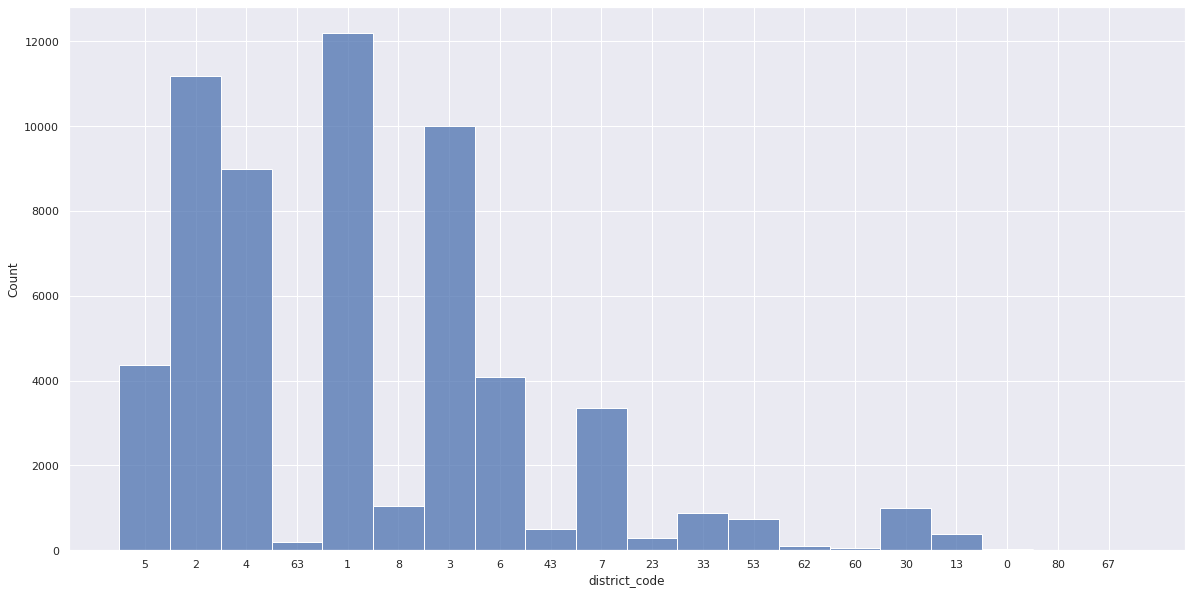

In [ ]:
sns.histplot(values['district_code'].astype(str))
values['district_code'].unique()

(0.0, 5000.0)

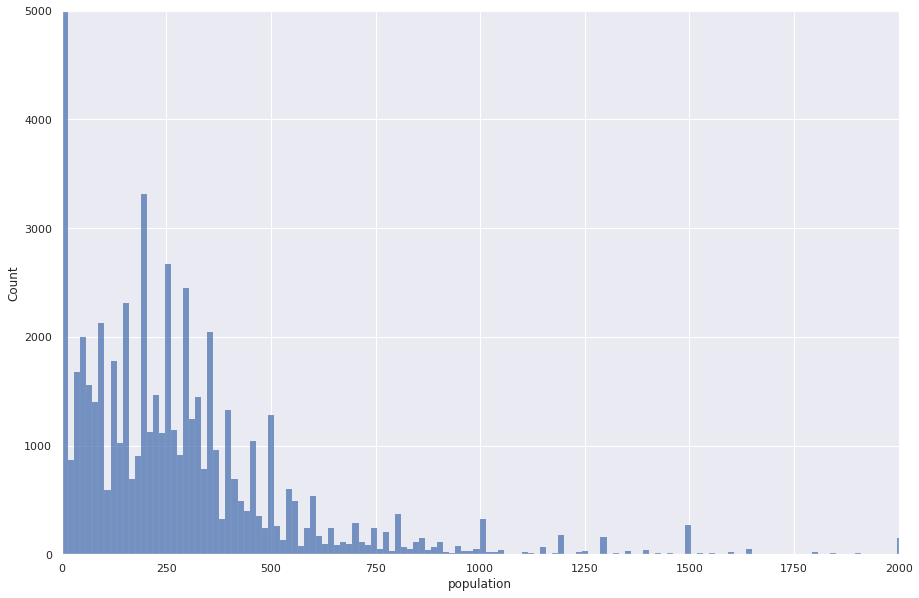

In [ ]:
sns.histplot(values['population'])
plt.xlim(0,2000)
plt.ylim(0,5000)

# Lot of zeroes. Mean impute: group by region

(1950.0, 2015.0)

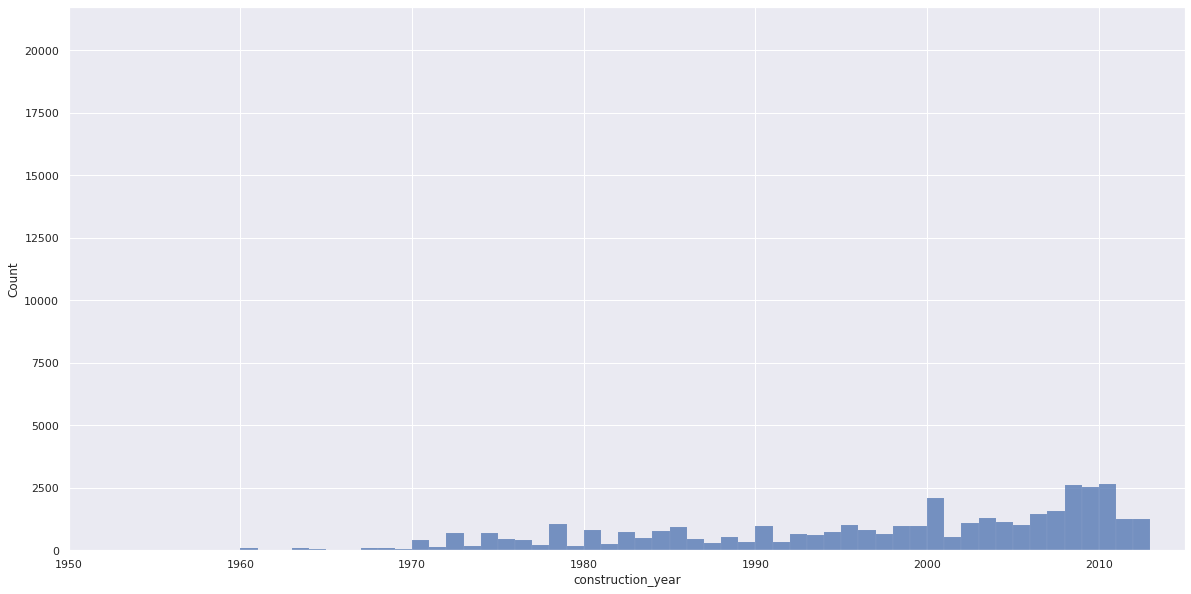

In [ ]:
sns.histplot(values['construction_year'], binwidth=1)
plt.xlim(1950,2015)

#Zero construction year- Impute ? Mean or based on gps height.




In [ ]:
values['construction_year'].describe()

count    59400.000000
mean      1300.652475
std        951.620547
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64